In [1]:
using GoldGates
using MSSim: Optimizers as Opts, SegSeq as SS, SymLinear as SL, Sequence as Seq, Utils as U
using BenchmarkTools
using NLopt
using Statistics
using PyPlot
using JSON
using Dates

include("../src/utils.jl")
ENV["MPLBACKEND"] = "module://matplotlib_inline.backend_inline"

"module://matplotlib_inline.backend_inline"

In [2]:
sysparams = open("../system_params/072125_goldparams_13ions.json") do io
    read(io, GoldGates.SystemParams; format=:json)
end;

In [39]:
# Constants across notebook
const nions = 13

const objfunc = Opts.autodiff(_objfunc);
const modes = Seq.Modes()
const ion1 = -2 + (nions + 1) ÷ 2
const ion2 = -4 + (nions + 1) ÷ 2
for i in 1:nions
    push!(modes, 2π * sysparams.modes.radial1[i], sysparams.participation_factors[i][ion1] * sysparams.participation_factors[i][ion2] * sysparams.lamb_dicke_parameters[i]^2)
end

In [40]:
const nseg = 25
buf_opt = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_allδ), Val(SS.mask_allδ));

amp_funcs = amp_base_funcs(nseg);
const nlmodel = Seq.Objective(SL.pmask_full,
    ((:dis2, 0), (:disδ2, 0), (:area, 0),
        (:areaδ, 0), (:τ, 0)),
    objfunc, modes, buf_opt,
    freq=Seq.FreqSpec(false, sym=true),    # turn off frequency modulation
    amp=Seq.AmpSpec(cb=amp_funcs, sym=true));

In [55]:
# Set bounds for optimizer
pitime_to_Ω(time) = π / (2 * time)
# this isn't a direct limit on rabi frequency though, just amplitude of each base function
Ωmax = pitime_to_Ω(30)
τmin = 5
τmax = 50
ωmin = 2π * (sysparams.modes.radial1[1])
ωmax = 2π * (sysparams.modes.radial1[3])

const nargs = Seq.nparams(nlmodel)
const tracker = Opts.NLVarTracker(nargs)
for Ω in nlmodel.param.Ωs
    # set the rabi frequency bound on all amplitude base function
    Opts.set_bound!(tracker, Ω, 0, Ωmax)
end
println("Ωmax is $Ωmax")

Opts.set_bound!(tracker, nlmodel.param.τ, τmin, τmax)
println("Total gate time is between $(τmin * nseg) and $(τmax * nseg) us")

for ω in nlmodel.param.ωs
    Opts.set_bound!(tracker, ω, ωmin, ωmax)
end

opt = NLopt.Opt(:LD_LBFGS, nargs)
NLopt.min_objective!(opt, nlmodel)
NLopt.lower_bounds!(opt, Opts.lower_bounds(tracker))
NLopt.upper_bounds!(opt, Opts.upper_bounds(tracker))
NLopt.maxtime!(opt, 10)

Ωmax is 0.05235987755982988
Total gate time is between 125 and 1250 us


In [56]:
best_obj = Inf
best_params = nothing
threshold = -Inf  # not setting a threshold

@time for i in 1:300
    global best_obj, best_params
    initial_params = Opts.init_vars!(tracker)
    obj, params, ret = @time NLopt.optimize(opt, initial_params)
    if getfield(NLopt, ret) < 0
        continue
    end
    if obj < best_obj
        best_obj = obj
        area = nlmodel(Val((:area, 0)), params)
        best_status = (
            obj = obj,
            dis = nlmodel(Val((:dis2, 0)), params),
            disδ = nlmodel(Val((:disδ2, 0)), params),
            area = area,
            areaε = abs(area) - π / 2,
            areaδ = nlmodel(Val((:areaδ, 0)), params),
            total_t = nlmodel(Val((:τ, 0)), params),
            Ωmax = params[nlmodel.param.Ωs[1]],
        )
        println(best_status)
        best_params = params
    end
    if best_obj < threshold
        break
    end
end

  0.010907 seconds (219 allocations: 53.078 KiB)
  0.038921 seconds (1.08 k allocations: 268.828 KiB)
  0.012306 seconds (310 allocations: 75.828 KiB)
(obj = 9.320998110464735, dis = 0.005677177189884379, disδ = 250.38297715205957, area = 1.3102437009839534, areaε = -0.2605526258109432, areaδ = -39.20624565171767, total_t = 301.56249232632155, Ωmax = 0.005046997104476653)
  0.040544 seconds (1.15 k allocations: 285.578 KiB)
(obj = 0.028545053086279183, dis = 9.366998747040963e-6, disδ = 2.843763955305619, area = 1.5701645599129674, areaε = -0.0006317668819291189, areaδ = -45.459432659838505, total_t = 1029.0775637565212, Ωmax = 0.0001428736311091587)
  0.014690 seconds (368 allocations: 90.328 KiB)
  0.012923 seconds (239 allocations: 58.078 KiB)
  0.037853 seconds (1.08 k allocations: 267.828 KiB)
  0.009358 seconds (229 allocations: 55.578 KiB)
  0.031005 seconds (825 allocations: 204.578 KiB)
  0.010634 seconds (264 allocations: 64.328 KiB)
  0.008897 seconds (172 allocations: 41.32

{
    "gradient_area_detuning": -29.201156790544445,
    "gradient_displacement_detuning": 0.002593238831741634,
    "enclosed_area": 0.780432044289195,
    "total_cumulative_displacement": 0.0025932388903392115,
    "carrier_pi_time_required": 4.536104318790698,
    "total_displacement": 3.2404099899038627e-9,
    "total_gate_time": 1141.005612804128
}



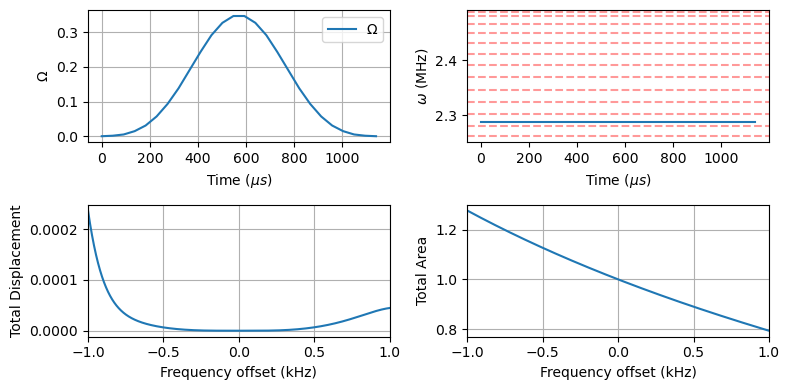

In [57]:
opt_raw_params, metadata = get_metadata_and_plot(nlmodel, best_params;)
println(JSON.json(metadata, 4))

In [ ]:
date = Dates.format(Dates.now(), "yyyymmdd")
filename = "../out/$(date)_am_$(nions)_v2.json"


_ion1 = ion1 - (nions + 1) ÷ 2
_ion2 = ion2 - (nions + 1) ÷ 2

ion_key = join(sort!([_ion1, _ion2], rev=true), ",")
new_xx_sol = GoldGates.XXSolution(
    opt_raw_params, 
    metadata["enclosed_area"], 
    metadata=JSON.json(metadata)
)

if isfile(filename)
    existing_file_content = open(filename, "r") do io
        JSON.parse(io)
    end
    
    xx_dict = get!(existing_file_content, "XX", Dict())
    xx_dict[ion_key] = new_xx_sol
    
    solution_data = existing_file_content
else
    solution_data = Dict(
        "XX" => Dict(ion_key => new_xx_sol),
        "modes" => Dict(
            "radial1" => sysparams.modes.radial1, # Assuming these exist in sysparams
            "axial" => [],
            "radial2" => []
        )
    )
end

open(filename, "w") do io
    JSON.print(io, solution_data, 2) # The '2' adds indentation for readability
end

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


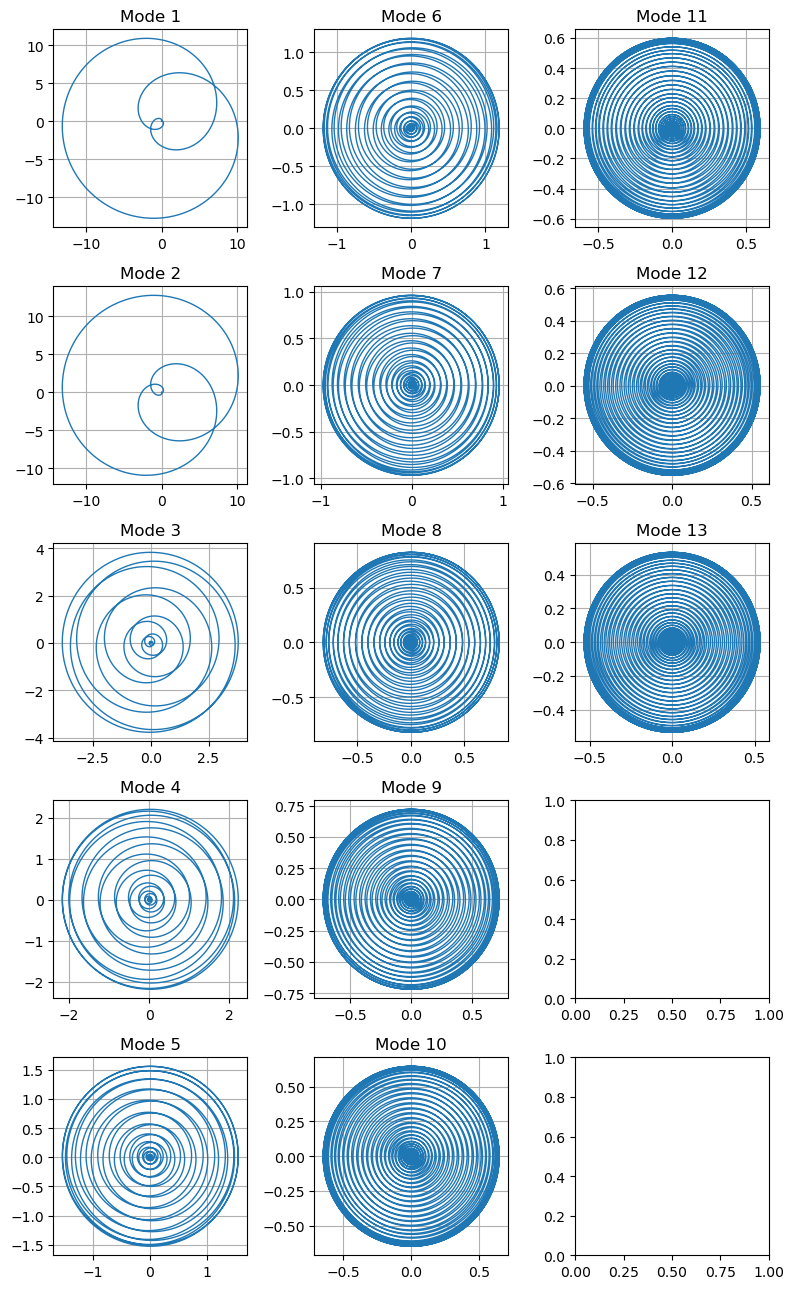

In [32]:
n = length(modes.modes)  # total number of modes
fig, axes = subplots(cld(n, 3), 3, figsize=(8, n))  # n vertical subplots

for i in 1:n
    _, xs, ys = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[i][1])
    ax = axes[i]
    ax.plot(xs, ys, lw=1)
    ax.set_title("Mode $i")
    ax.grid(true)
end

tight_layout()
show()

In [33]:
fieldnames(typeof(sysparams.modes))

(:radial1, :radial2, :axial)